## RQ1: How relevant is the topic?

## Results using data until 2023

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
github_actions_df = pd.read_csv(f'..\RQ1_Relevance\data\github-actions.csv')
jenkins_df = pd.read_csv(f'..\RQ1_Relevance\data\jenkins.csv')
gitlab_ci_df = pd.read_csv(f'..\RQ1_Relevance\data\gitlab-ci.csv')
azure_devops_df = pd.read_csv(f'..\RQ1_Relevance\data\\azure-devops.csv')
circleci_df = pd.read_csv(f'..\RQ1_Relevance\data\circleci.csv')
travis_ci_df = pd.read_csv(f'..\RQ1_Relevance\data\\travis-ci.csv')  

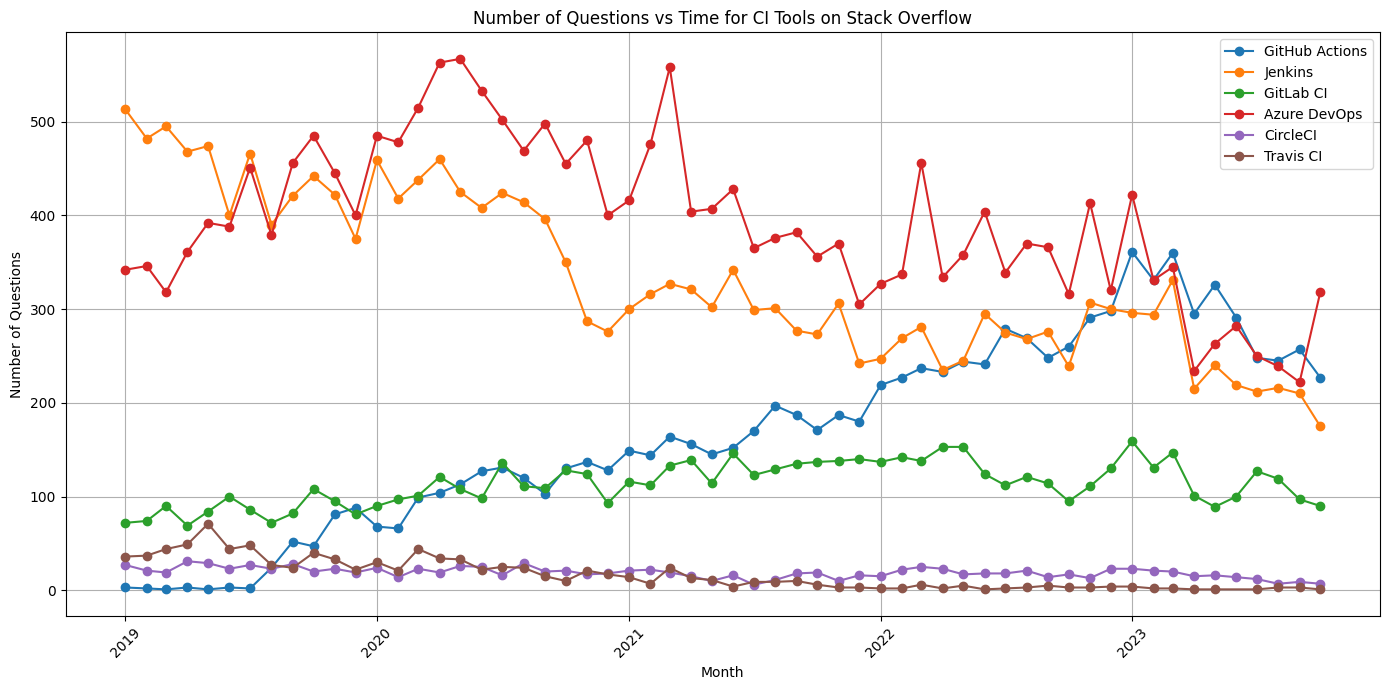

In [2]:

github_actions_df['Month'] = pd.to_datetime(github_actions_df['Month'])
jenkins_df['Month'] = pd.to_datetime(jenkins_df['Month'])
gitlab_ci_df['Month'] = pd.to_datetime(gitlab_ci_df['Month'])
azure_devops_df['Month'] = pd.to_datetime(azure_devops_df['Month'])
circleci_df['Month'] = pd.to_datetime(circleci_df['Month'])
travis_ci_df['Month'] = pd.to_datetime(travis_ci_df['Month'])  

# Plotting
plt.figure(figsize=(14, 7))

# Plot each CI tool's data
plt.plot(github_actions_df['Month'], github_actions_df['NumberOfQuestions'], label='GitHub Actions', marker='o')
plt.plot(jenkins_df['Month'], jenkins_df['NumberOfQuestions'], label='Jenkins', marker='o')
plt.plot(gitlab_ci_df['Month'], gitlab_ci_df['NumberOfQuestions'], label='GitLab CI', marker='o')
plt.plot(azure_devops_df['Month'], azure_devops_df['NumberOfQuestions'], label='Azure DevOps', marker='o')
plt.plot(circleci_df['Month'], circleci_df['NumberOfQuestions'], label='CircleCI', marker='o')
plt.plot(travis_ci_df['Month'], travis_ci_df['NumberOfQuestions'], label='Travis CI', marker='o')  # This is not provided, hence commented out.

# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions vs Time for CI Tools on Stack Overflow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the plot
plt.show()


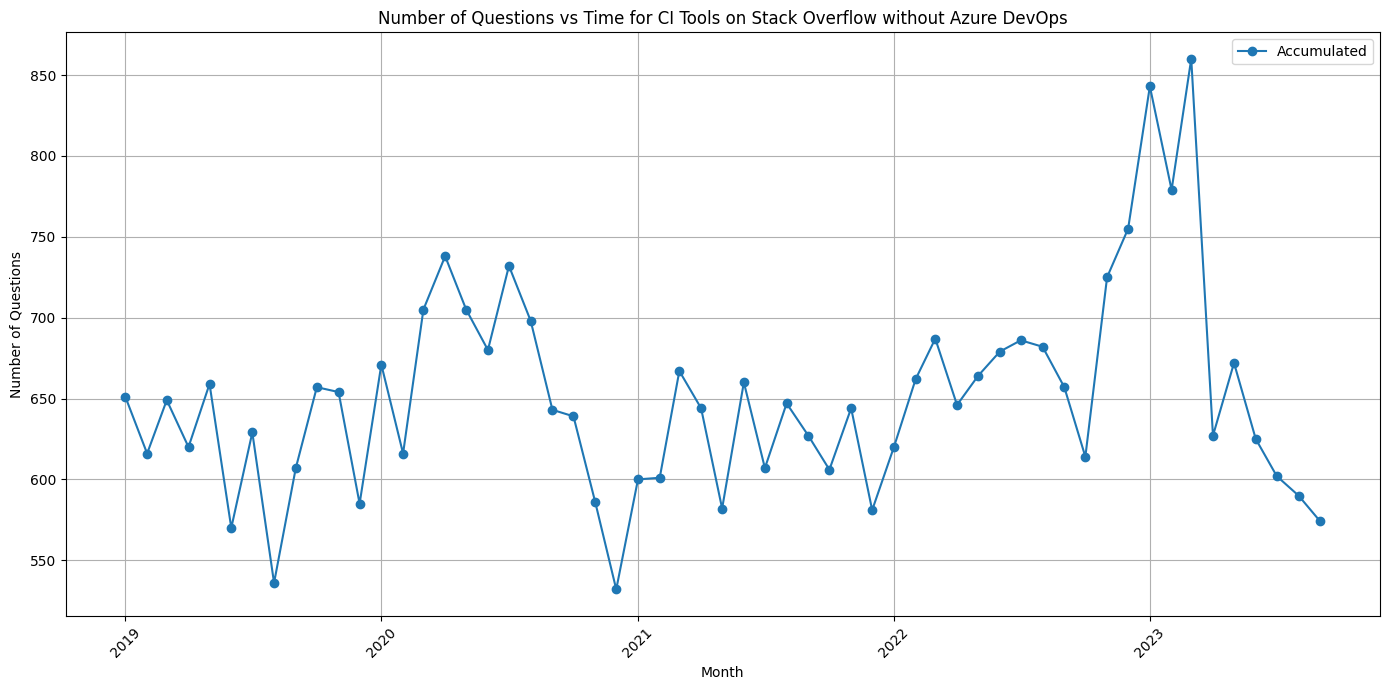

In [3]:
accumulated_df = pd.DataFrame()
accumulated_df['Month'] = github_actions_df['Month']
accumulated_df['NumberOfQuestions'] = github_actions_df['NumberOfQuestions'] + jenkins_df['NumberOfQuestions'] + gitlab_ci_df['NumberOfQuestions'] + azure_devops_df['NumberOfQuestions'] + circleci_df['NumberOfQuestions'] + travis_ci_df['NumberOfQuestions']
accumulated_df['NumberOfQuestions'] = github_actions_df['NumberOfQuestions'] + jenkins_df['NumberOfQuestions'] + gitlab_ci_df['NumberOfQuestions'] + circleci_df['NumberOfQuestions'] + travis_ci_df['NumberOfQuestions']

plt.figure(figsize=(14, 7))
plt.plot(accumulated_df['Month'], accumulated_df['NumberOfQuestions'], label='Accumulated', marker='o')
# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions vs Time for CI Tools on Stack Overflow without Azure DevOps')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() 

# Show the plot
plt.show()

In [4]:
# Total number of SO posts for each ci tool

print(github_actions_df['NumberOfQuestions'].sum())
print(jenkins_df['NumberOfQuestions'].sum())
print(gitlab_ci_df['NumberOfQuestions'].sum())
print(azure_devops_df['NumberOfQuestions'].sum())
print(circleci_df['NumberOfQuestions'].sum())
print(travis_ci_df['NumberOfQuestions'].sum())

9622
19354
6581
22797
1095
940


## Results using data until 2024

Data was collected using SEDE (Stack Exchange Data Explorer), focusing on the six most relevant CI/CD tools. The data spans from 2019 to August 3, 2024.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the three datasets
df_2019_2020 = pd.read_csv(f'..\RQ1_Relevance\data\cicd_tools_stackoverflow_2019_2021.csv')
df_2021_2022 = pd.read_csv(f'..\RQ1_Relevance\data\cicd_tools_stackoverflow_2021_2023.csv')
df_2023_2024 = pd.read_csv(f'..\RQ1_Relevance\data\cicd_tools_stackoverflow_2023_.csv')

# Combine the datasets into a single DataFrame
df = pd.concat([df_2019_2020, df_2021_2022, df_2023_2024])

# Convert CreationDate to datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

# List of CI/CD tools
cicd_tools = ['github-actions', 'jenkins', 'gitlab-ci', 'azure-devops', 'travis-ci', 'circleci']

In [6]:
# Count the number of posts by each TagName
tagname_counts = df['TagName'].value_counts()
print('Number of posts by tool:', tagname_counts)

# Calculate the total number of posts
total_posts = df.shape[0]
print('Total number of posts:', total_posts)

Number of posts by tool: TagName
azure-devops      24620
jenkins           19850
github-actions    10862
gitlab-ci          7020
circleci           1086
travis-ci           940
Name: count, dtype: int64
Total number of posts: 64378


### 1.- Popularity over time

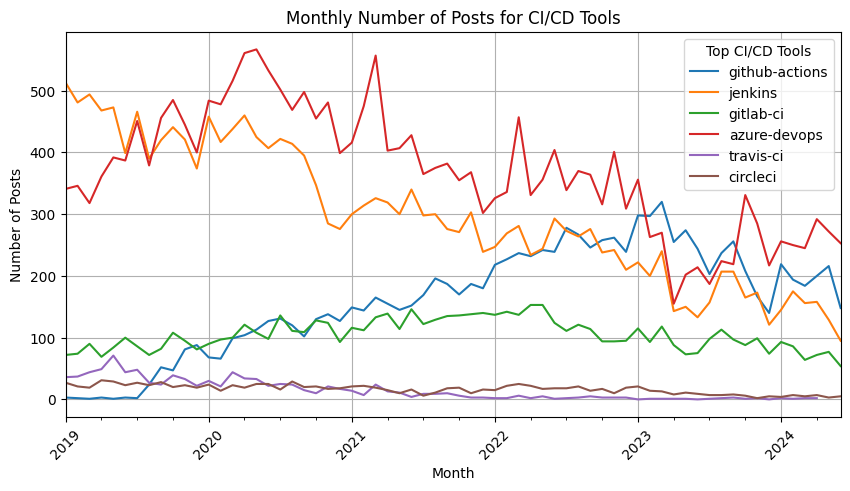

In [7]:
# Initialize a dictionary to store the results
results_score = {}
monthly_posts_data = {}

for tool in cicd_tools:
    # print(f"Analyzing data for {tool}...")
    
    # Filter data for the current tool
    tool_df = df[df['TagName'] == tool]
    
    # Separate questions and answers
    questions = tool_df[tool_df['PostTypeId'] == 1].copy()
    answers = tool_df[tool_df['PostTypeId'] == 2].copy()

    # Calculate Metrics
    avg_view = questions['ViewCount'].mean()
    avg_fav = questions['FavoriteCount'].mean()
    avg_score = questions['Score'].mean()
    avg_ans = questions['AnswerCount'].mean()
    avg_answer_score = answers['Score'].mean() if not answers.empty else float('nan')
    total_answers = questions['AnswerCount'].sum()
    total_questions = questions.shape[0]
    answers_per_question = total_answers / total_questions if total_questions > 0 else float('nan')
    unanswered_questions = questions[questions['AnswerCount'] == 0].shape[0]
    unanswered_question_ratio = unanswered_questions / total_questions if total_questions > 0 else float('nan')
    
    # Response Time Calculation
    merged_df = pd.merge(answers, questions[['PostId', 'CreationDate']], left_on='ParentId', right_on='PostId', suffixes=('_answer', '_question'))
    merged_df['responseTime'] = (merged_df['CreationDate_answer'] - merged_df['CreationDate_question']).dt.total_seconds() / 3600
    avg_response_time = merged_df['responseTime'].mean()
    
    # Store results in the dictionary
    results_score[tool] = {
        'avg_view': avg_view,
        'avg_fav': avg_fav,
        'avg_score': avg_score,
        'avg_ans': avg_ans,
        'avg_answer_score': avg_answer_score,
        'answers_per_question': answers_per_question,
        'unanswered_question_ratio': unanswered_question_ratio,
        'avg_response_time': avg_response_time,
        'total_questions': total_questions
    }

    # Calculate monthly number of posts
    monthly_posts = tool_df.resample('M', on='CreationDate').size()
    monthly_posts_data[tool] = monthly_posts

# Step 1: Find the last complete month
last_complete_month = df['CreationDate'].max().replace(day=1) - pd.offsets.MonthBegin(1)

# Step 2: Filter the monthly_posts_data to include only data up to the last complete month
filtered_monthly_posts_data = {tool: data[data.index <= last_complete_month] for tool, data in monthly_posts_data.items()}

# Step 3: Plot the filtered data
plt.figure(figsize=(10, 5))
for tool in cicd_tools:
    filtered_monthly_posts_data[tool].plot(label=tool)

plt.title('Monthly Number of Posts for CI/CD Tools')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(title="Top CI/CD Tools")
plt.xticks(rotation=45)
plt.grid(True)

# Save the plot to a file named 'figs.png'
plt.savefig('figs/ci_tools_until_Jul_2024.png')

plt.show()

In [8]:
last_complete_month

Timestamp('2024-07-01 20:15:17')

In [9]:
# Extract the year from the CreationDate
df['Year'] = df['CreationDate'].dt.year

# Filter only questions (PostTypeId == 1)
questions_df = df[df['PostTypeId'] == 1]

# Group by Year and TagName, then count the number of questions
yearly_question_count = questions_df.groupby(['Year', 'TagName']).size().unstack(fill_value=0)

# Display the table
print(yearly_question_count)

TagName  azure-devops  circleci  github-actions  gitlab-ci  jenkins  travis-ci
Year                                                                          
2019             4761       290             307       1013     5340        474
2020             5943       251            1325       1315     4744        296
2021             4833       183            1999       1560     3586        113
2022             4309       218            2945       1475     3071         37
2023             2923       111            2899       1131     2118         13
2024             1851        33            1387        526      991          7


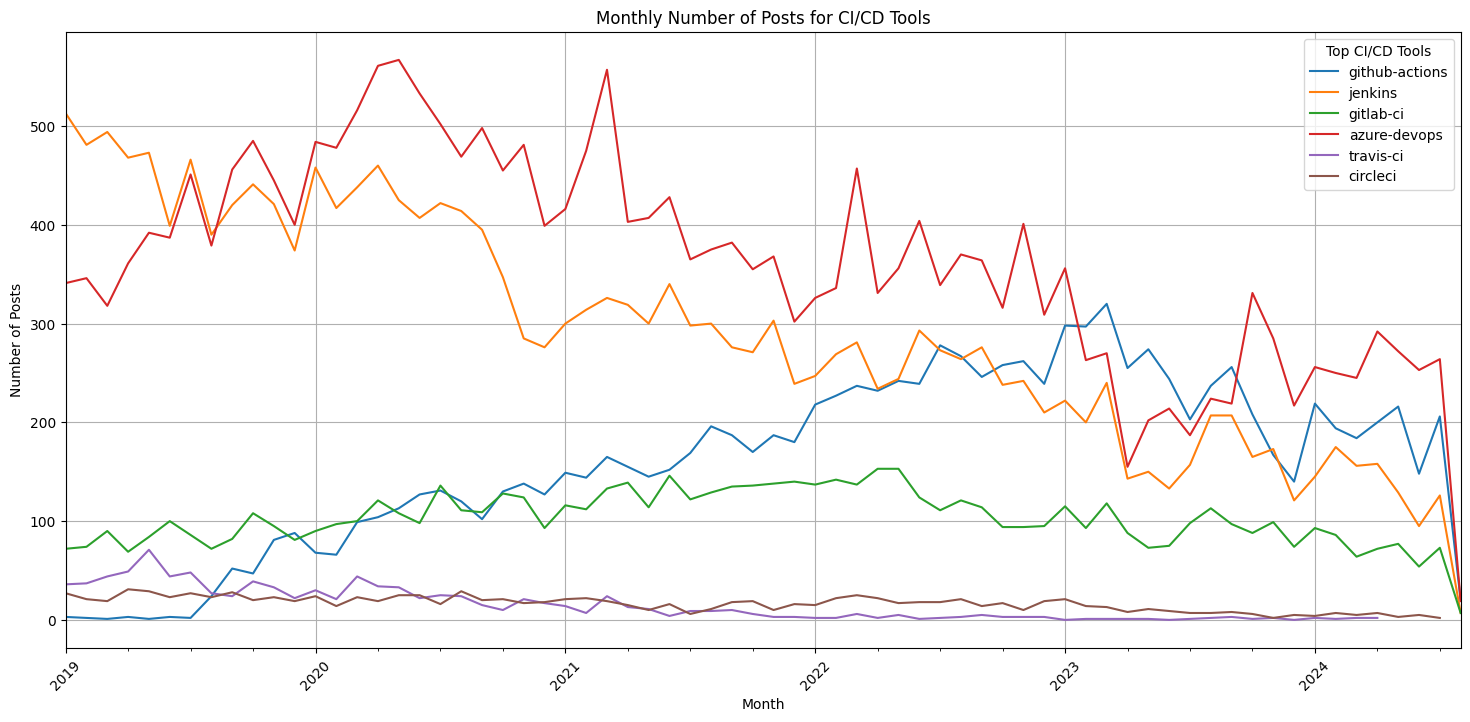

In [10]:
import matplotlib.pyplot as plt

# Plot Monthly Number of Posts for Each Tool
plt.figure(figsize=(18, 8))
for tool in cicd_tools:
    monthly_posts_data[tool].plot(label=tool)

plt.title('Monthly Number of Posts for CI/CD Tools')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(title="Top CI/CD Tools")
plt.xticks(rotation=45)
plt.grid(True)

# Save the plot to a file named 'figs.png'
plt.savefig('figs/ci_tools.png')

# Show the plot (optional, if you also want to display it)
plt.show()

## 2.- Percentage of Non Answered questions (%nAA) and Average Response Time (RT) over time

To obatain the RT of a questions, we calculate the amount of time between when the question is made and when the accepted answer is posted.

In [11]:
# Load the three datasets of answers
df_answers_2019_2021 = pd.read_csv(f'..\RQ1_Relevance\data\\answers_2019_to_2021.csv')
df_answers_2021_2022 = pd.read_csv(f'..\RQ1_Relevance\data\\answers_2021_to_2022.csv')
df_answers_2022_ = pd.read_csv(f'..\RQ1_Relevance\data\\answers_2022_to_.csv')

# Combine the datasets into a single DataFrame
df_answers = pd.concat([df_answers_2019_2021, df_answers_2021_2022, df_answers_2022_])

In [12]:
df_answers.columns

Index(['QuestionId', 'QuestionTitle', 'QuestionCreationDate', 'TagName',
       'AnswerId', 'AnswerCreationDate', 'AnswerScore', 'IsAcceptedAnswer',
       'AnswerBody', 'AnswerAuthorName', 'AnswerAuthorReputation',
       'TimeToFirstAnswer'],
      dtype='object')

In [13]:
# Assuming 'df' is your DataFrame

# Step 1: Extract the year from the 'CreationDate' column
df['Year'] = pd.to_datetime(df['CreationDate']).dt.year

# Step 2: Group by 'TagName' and 'Year'
grouped = df.groupby(['TagName', 'Year'])

# Step 3: Calculate %nAA for each tool and year
results_score = []

for (tag, year), group in grouped:
    # Total number of questions
    total_questions = len(group)
    
    # Number of questions without an accepted answer
    no_accepted_answer = group['AcceptedAnswerId'].isna().sum()
    
    # Calculate %nAA
    percent_nAA = (no_accepted_answer / total_questions) * 100 if total_questions > 0 else 0
    
    # Store the results
    results_score.append({
        'Year': year,
        'Tool': tag,
        'Total Questions': total_questions,
        '%nAA': round(percent_nAA, 2)
    })

# Convert the results to a DataFrame
results_nAA_df = pd.DataFrame(results_score).sort_values(by=['Year','Tool'])

# Display the results
results_nAA_df.reset_index(drop=True)

,Year,Tool,Total Questions,%nAA
0,2019,azure-devops,4761,46.99
1,2019,circleci,290,54.83
2,2019,github-actions,307,34.53
3,2019,gitlab-ci,1013,57.95
4,2019,jenkins,5340,67.25
5,2019,travis-ci,474,58.86
6,2020,azure-devops,5943,39.93
7,2020,circleci,251,58.96
8,2020,github-actions,1325,49.96
9,2020,gitlab-ci,1315,60.68


In [14]:
# Assuming 'df' is your DataFrame

# Step 1: Extract the year from the 'CreationDate' column
df['Year'] = pd.to_datetime(df['CreationDate']).dt.year

# Step 2: Group by 'TagName' and 'Year'
grouped = df.groupby(['TagName', 'Year'])

# Step 3: Calculate the average score for each tool and year
results_score = []

for (tag, year), group in grouped:
    # Total number of questions
    total_questions = len(group)
    
    # Calculate average score for the group
    avg_score = group['Score'].mean() if total_questions > 0 else 0
    
    # Store the results
    results_score.append({
        'Year': year,
        'Tool': tag,
        'Total Questions': total_questions,
        'Average Score': round(avg_score, 2)
    })

# Convert the results to a DataFrame
results_score_df = pd.DataFrame(results_score).sort_values(by=['Year','Tool'])

# Display the results
results_score_df.reset_index(drop=True)

# Show the results
results_score_df


,Year,Tool,Total Questions,Average Score
0,2019,azure-devops,4761,2.49
6,2019,circleci,290,2.10
12,2019,github-actions,307,25.21
18,2019,gitlab-ci,1013,3.19
24,2019,jenkins,5340,1.23
30,2019,travis-ci,474,1.65
1,2020,azure-devops,5943,1.64
7,2020,circleci,251,1.46
13,2020,github-actions,1325,6.94
19,2020,gitlab-ci,1315,2.83


In [15]:
import pandas as pd

# Step 1: Filter for only accepted answers
df_accepted_answers = df_answers[df_answers['IsAcceptedAnswer'] == 1]

# Step 2: Calculate RT as the difference between QuestionCreationDate and AnswerCreationDate
df_accepted_answers['RT'] = pd.to_datetime(df_accepted_answers['AnswerCreationDate']) - pd.to_datetime(df_accepted_answers['QuestionCreationDate'])

# Step 3: Convert RT from a timedelta to days
df_accepted_answers['RT (Average Response Time in Days)'] = df_accepted_answers['RT'].dt.total_seconds() / (24 * 60 * 60)

# Step 4: Extract the year from the QuestionCreationDate
df_accepted_answers['Year'] = pd.to_datetime(df_accepted_answers['QuestionCreationDate']).dt.year

# Step 5: Group by 'TagName' and 'Year' and calculate the average response time
avg_rt_df = df_accepted_answers.groupby(['TagName', 'Year']).agg({
    'RT (Average Response Time in Days)': 'mean'
}).reset_index()

# Step 6: Rename 'TagName' to 'Tool' for clarity
avg_rt_df.rename(columns={'TagName': 'Tool'}, inplace=True)

# Step 7: Sort the DataFrame by 'Year' and 'Tool'
avg_rt_df.sort_values(by=['Year', 'Tool'], inplace=True)

# Display the results
avg_rt_df.reset_index(drop=True, inplace=True)
avg_rt_df = avg_rt_df[['Year', 'Tool', 'RT (Average Response Time in Days)']]

avg_rt_df;

C:\Users\shern\AppData\Local\Temp\ipykernel_2580\437043275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted_answers['RT'] = pd.to_datetime(df_accepted_answers['AnswerCreationDate']) - pd.to_datetime(df_accepted_answers['QuestionCreationDate'])
C:\Users\shern\AppData\Local\Temp\ipykernel_2580\437043275.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted_answers['RT (Average Response Time in Days)'] = df_accepted_answers['RT'].dt.total_seconds() / (24 * 60 * 60)
C:\Users\shern\AppD

In [16]:
# Remove the year 2024
combined_df = pd.merge(results_nAA_df, avg_rt_df, on=['Year', 'Tool'])
filtered_df = combined_df[combined_df['Year'] != 2024]
# Merge the avg_score_df with your existing combined DataFrame
final_df = pd.merge(filtered_df, results_score_df, on=['Year', 'Tool'])

# Drop the duplicate column
final_df = final_df.drop(columns=['Total Questions_y'])

# Rename the remaining Total Questions column
final_df.rename(columns={'Total Questions_x': 'Total Questions'}, inplace=True)

# Display the updated DataFrame
final_df

,Year,Tool,Total Questions,%nAA,RT (Average Response Time in Days),Average Score
0,2019,azure-devops,4761,46.99,13.858153,2.49
1,2019,circleci,290,54.83,18.118902,2.10
2,2019,github-actions,307,34.53,47.933771,25.21
3,2019,gitlab-ci,1013,57.95,42.620352,3.19
4,2019,jenkins,5340,67.25,22.710273,1.23
5,2019,travis-ci,474,58.86,18.501340,1.65
6,2020,azure-devops,5943,39.93,8.981659,1.64
7,2020,circleci,251,58.96,11.128101,1.46
8,2020,github-actions,1325,49.96,36.559556,6.94
9,2020,gitlab-ci,1315,60.68,26.439189,2.83


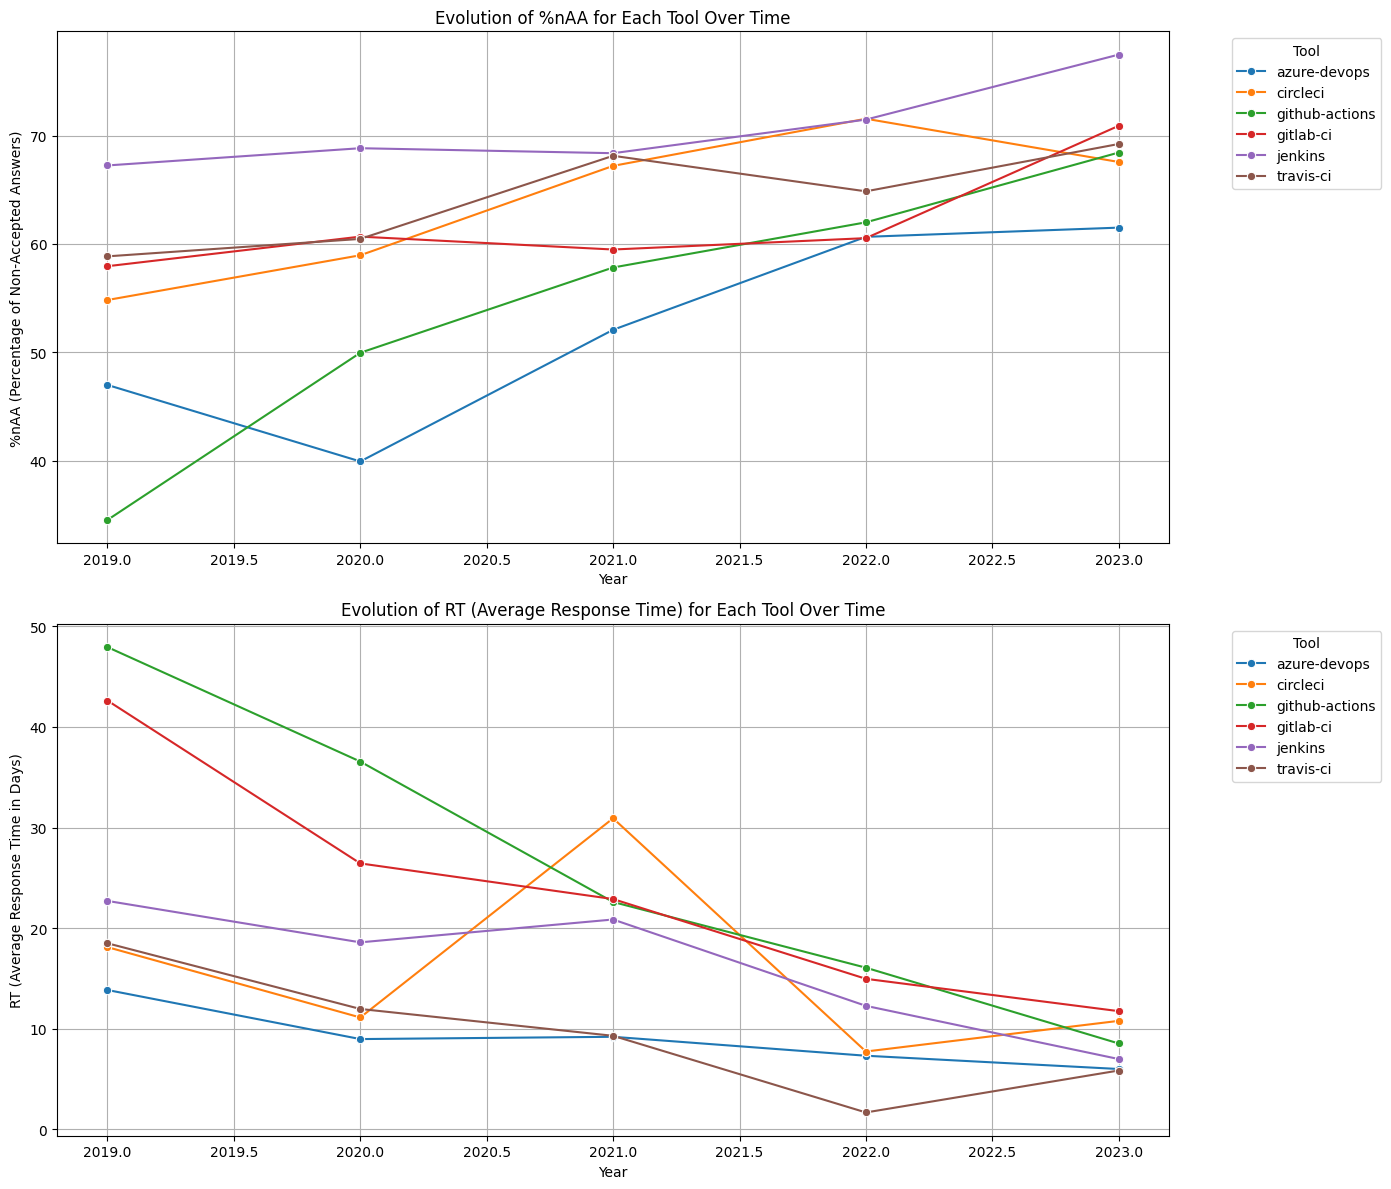

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size
plt.figure(figsize=(14, 12))

# Plot 1: Evolution of %nAA for each tool over time
plt.subplot(2, 1, 1)
sns.lineplot(x='Year', y='%nAA', hue='Tool', data=filtered_df, marker='o')
plt.title('Evolution of %nAA for Each Tool Over Time')
plt.xlabel('Year')
plt.ylabel('%nAA (Percentage of Non-Accepted Answers)')
plt.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 2: Evolution of RT for each tool over time
plt.subplot(2, 1, 2)
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', hue='Tool', data=filtered_df, marker='o')
plt.title('Evolution of RT (Average Response Time) for Each Tool Over Time')
plt.xlabel('Year')
plt.ylabel('RT (Average Response Time in Days)')
plt.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file named 'figs.png'
plt.savefig('figs/nAA_RT_vs_time_each_tool.png')

# Show the plots
plt.show()

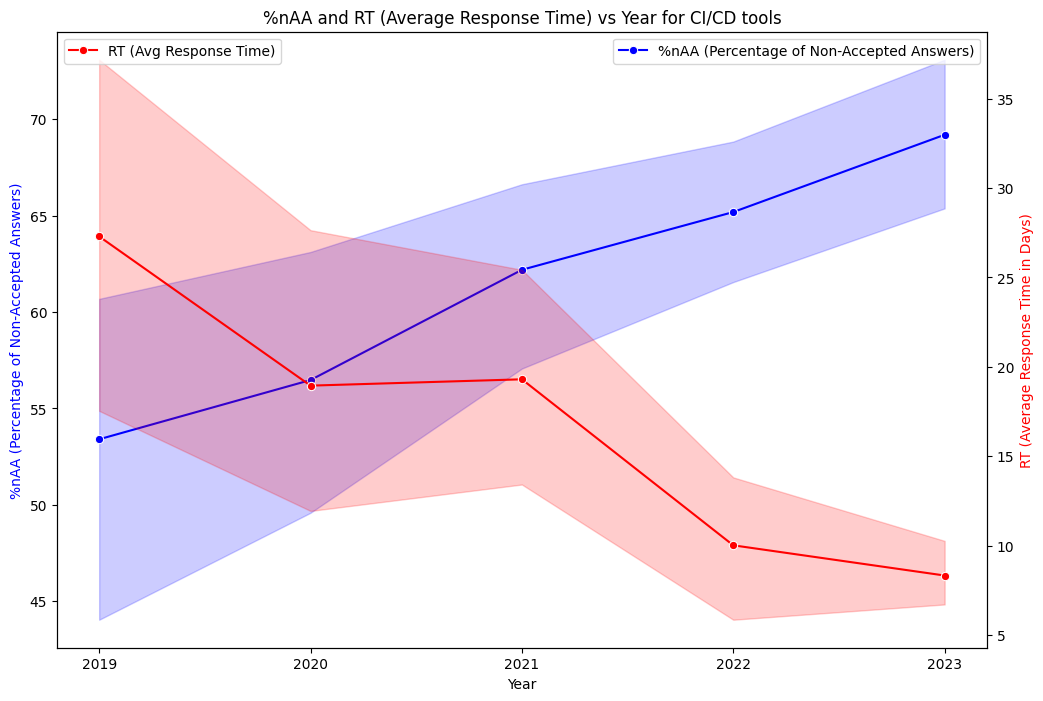

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for GitHub Actions
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting %nAA vs Year for GitHub Actions on the primary y-axis
sns.lineplot(x='Year', y='%nAA', data=filtered_df, marker='o', ax=ax1, label='%nAA (Percentage of Non-Accepted Answers)', color='b')

# Creating a second y-axis for RT
ax2 = ax1.twinx()

# Plotting RT vs Year on the second y-axis for GitHub Actions
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=filtered_df, marker='o', ax=ax2, label='RT (Avg Response Time)', color='r')

# Labels and title
plt.title('%nAA and RT (Average Response Time) vs Year for CI/CD tools')
ax1.set_xlabel('Year')
ax1.set_ylabel('%nAA (Percentage of Non-Accepted Answers)', color='b')
ax2.set_ylabel('RT (Average Response Time in Days)', color='r')

# Customizing the legends: Place the %nAA legend on the right and RT on the left
ax1.legend(loc='upper right')  # %nAA legend on the right
ax2.legend(loc='upper left')   # RT legend on the left

# Set x-ticks to display only specific years
ax1.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file named 'figs.png'
plt.savefig('figs/nAA_RT_vs_time.png')

# Show the plot
plt.show()

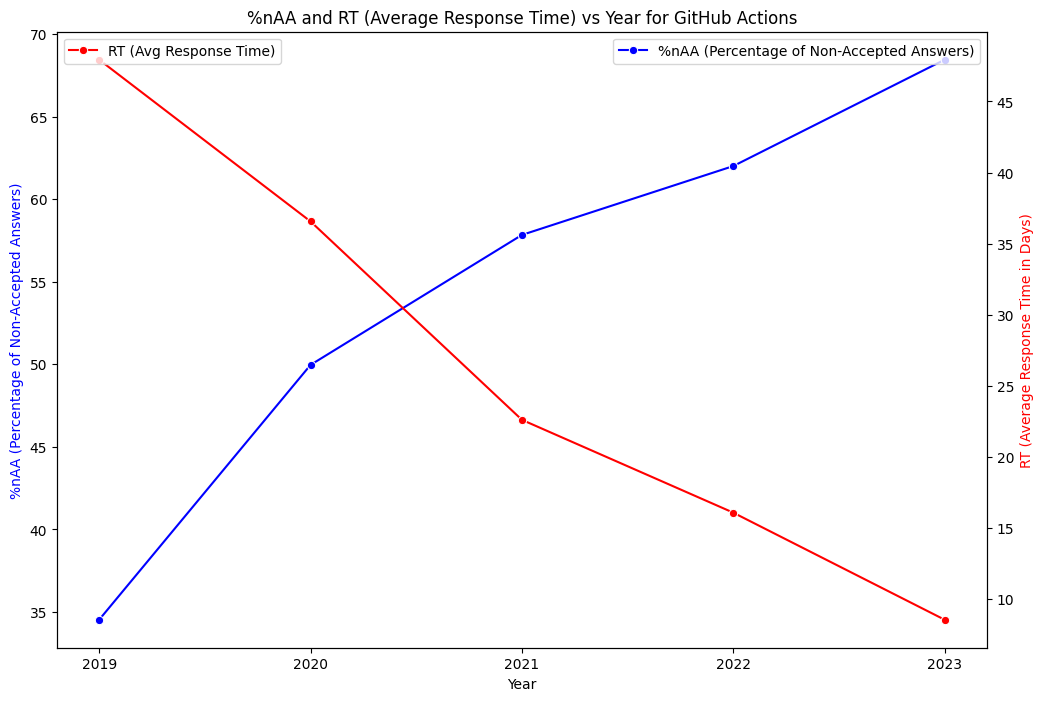

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for GitHub Actions
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting %nAA vs Year for GitHub Actions on the primary y-axis
sns.lineplot(x='Year', y='%nAA', data=gha_df, marker='o', ax=ax1, label='%nAA (Percentage of Non-Accepted Answers)', color='b')

# Creating a second y-axis for RT
ax2 = ax1.twinx()

# Plotting RT vs Year on the second y-axis for GitHub Actions
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=gha_df, marker='o', ax=ax2, label='RT (Avg Response Time)', color='r')

# Labels and title
plt.title('%nAA and RT (Average Response Time) vs Year for GitHub Actions')
ax1.set_xlabel('Year')
ax1.set_ylabel('%nAA (Percentage of Non-Accepted Answers)', color='b')
ax2.set_ylabel('RT (Average Response Time in Days)', color='r')

# Customizing the legends: Place the %nAA legend on the right and RT on the left
ax1.legend(loc='upper right')  # %nAA legend on the right
ax2.legend(loc='upper left')   # RT legend on the left

# Set x-ticks to display only specific years
ax1.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file named 'figs.png'
plt.savefig('figs/nAA_RT_vs_time_gha.png')

# Show the plot
plt.show()

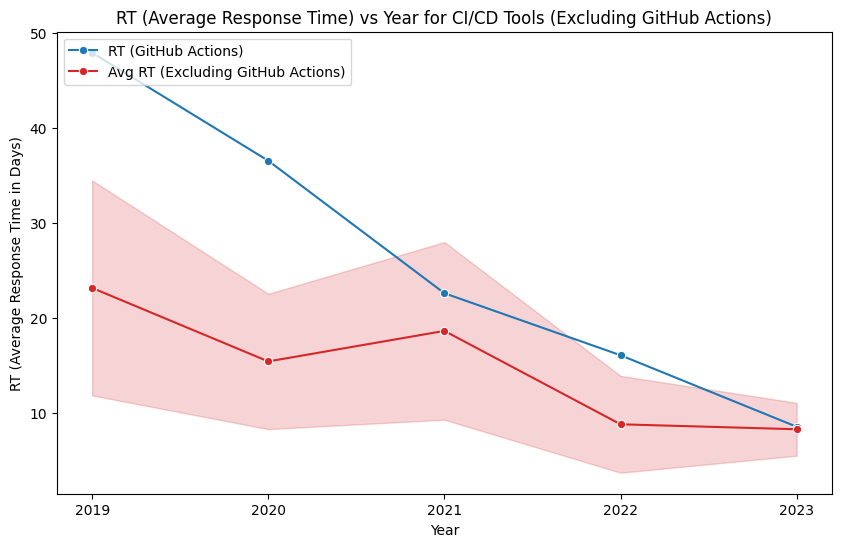

In [39]:
# Filter the data for GitHub Actions and other tools separately
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']
other_tools_df = filtered_df[filtered_df['Tool'] != 'github-actions']

# Calculate the average and standard deviation for RT for all tools except GitHub Actions
avg_other_tools = other_tools_df.groupby('Year').agg({
    'RT (Average Response Time in Days)': 'mean'
}).reset_index()

std_other_tools = other_tools_df.groupby('Year').agg({
    'RT (Average Response Time in Days)': 'std'
}).reset_index()

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting RT vs Year for other tools (average)
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=gha_df, marker='o', ax=ax, label='RT (GitHub Actions)', color='#1f77b4')
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=avg_other_tools, marker='o', ax=ax, label='Avg RT (Excluding GitHub Actions)', color='#d62728')

# Adding shaded area for RT standard deviation
ax.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['RT (Average Response Time in Days)'] - std_other_tools['RT (Average Response Time in Days)'], 
                 avg_other_tools['RT (Average Response Time in Days)'] + std_other_tools['RT (Average Response Time in Days)'], 
                 color='#d62728', alpha=0.2)

# Labels and title
plt.title('RT (Average Response Time) vs Year for CI/CD Tools (Excluding GitHub Actions)')
ax.set_xlabel('Year')
ax.set_ylabel('RT (Average Response Time in Days)')

# Customizing the legend
ax.legend(loc='upper left')  # RT legends

# Set x-ticks to display only specific years
ax.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file
plt.savefig('figs/RT_vs_time_excluding_gha.png')

# Show the plot
plt.show()


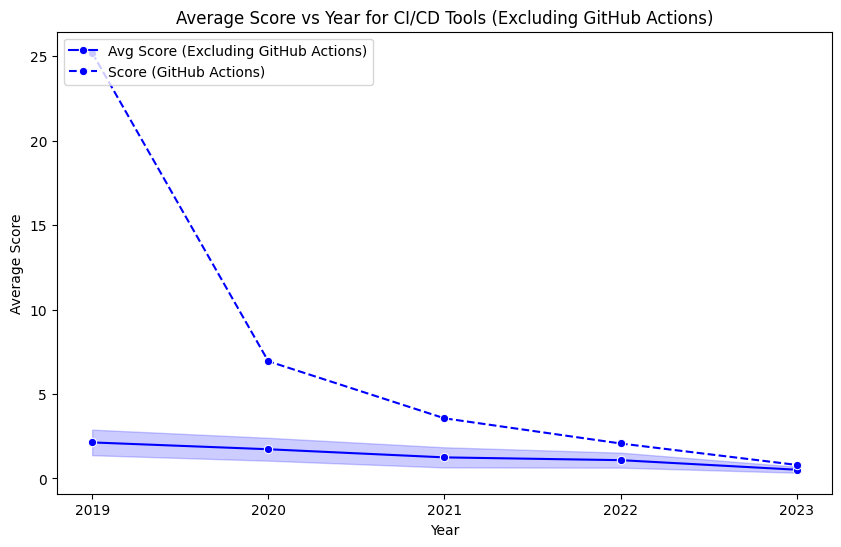

In [21]:
# Filter the data for GitHub Actions and other tools separately
gha_df = final_df[final_df['Tool'] == 'github-actions']
other_tools_df = final_df[final_df['Tool'] != 'github-actions']

# Calculate the average and standard deviation for Average Score for all tools except GitHub Actions
avg_other_tools = other_tools_df.groupby('Year').agg({
    'Average Score': 'mean'
}).reset_index()

std_other_tools = other_tools_df.groupby('Year').agg({
    'Average Score': 'std'
}).reset_index()

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting Average Score vs Year for other tools (average)
sns.lineplot(x='Year', y='Average Score', data=avg_other_tools, marker='o', ax=ax, label='Avg Score (Excluding GitHub Actions)', color='b')
sns.lineplot(x='Year', y='Average Score', data=gha_df, marker='o', ax=ax, label='Score (GitHub Actions)', color='blue', linestyle='--')

# Adding shaded area for Average Score standard deviation
ax.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['Average Score'] - std_other_tools['Average Score'], 
                 avg_other_tools['Average Score'] + std_other_tools['Average Score'], 
                 color='b', alpha=0.2)

# Labels and title
plt.title('Average Score vs Year for CI/CD Tools (Excluding GitHub Actions)')
ax.set_xlabel('Year')
ax.set_ylabel('Average Score')

# Customizing the legend
ax.legend(loc='upper left')

# Set x-ticks to display only specific years
ax.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file
plt.savefig('figs/Score_vs_time_excluding_gha.png')

# Show the plot
plt.show()

## 3.- Correlation between %nAA and RT

In [22]:
# Initialize a dictionary to store the correlation results for each tool
correlation_results = {}

# List of unique tools
tools = filtered_df['Tool'].unique()

# Calculate correlation between %nAA and RT for each tool
for tool in tools:
    tool_df = filtered_df[filtered_df['Tool'] == tool]
    correlation = tool_df['%nAA'].corr(tool_df['RT (Average Response Time in Days)'])
    correlation_results[tool] = correlation

# Convert the results to a DataFrame for better visualization
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation (%nAA vs RT)'])

# Calculate the overall correlation between %nAA and RT for the entire dataset
overall_correlation = filtered_df['%nAA'].corr(filtered_df['RT (Average Response Time in Days)'])
print(f"Overall Correlation (%nAA vs RT): {overall_correlation:.2f}")

# Add the overall correlation to the DataFrame
correlation_df.loc['Overall'] = overall_correlation

# Display the final results
print(correlation_df)

Overall Correlation (%nAA vs RT): -0.45
                Correlation (%nAA vs RT)
azure-devops                   -0.615948
circleci                       -0.109088
github-actions                 -0.984399
gitlab-ci                      -0.690472
jenkins                        -0.964885
travis-ci                      -0.701523
Overall                        -0.445850


## 4.- Correlation between %nAA and RT vs popularity

In [23]:
# Initialize a dictionary to store the correlation results for each tool
correlation_results_nAA_popularity = {}
correlation_results_RT_popularity = {}

# List of unique tools
tools = filtered_df['Tool'].unique()

# Calculate correlations for each tool
for tool in tools:
    tool_df = filtered_df[filtered_df['Tool'] == tool]
    
    # Correlation between %nAA and Popularity (Total Questions)
    corr_nAA_popularity = tool_df['%nAA'].corr(tool_df['Total Questions'])
    correlation_results_nAA_popularity[tool] = corr_nAA_popularity
    
    # Correlation between RT and Popularity (Total Questions)
    corr_RT_popularity = tool_df['RT (Average Response Time in Days)'].corr(tool_df['Total Questions'])
    correlation_results_RT_popularity[tool] = corr_RT_popularity

# Convert the results to DataFrames for better visualization
correlation_df_nAA_popularity = pd.DataFrame.from_dict(correlation_results_nAA_popularity, orient='index', columns=['Correlation (%nAA vs Popularity)'])
correlation_df_RT_popularity = pd.DataFrame.from_dict(correlation_results_RT_popularity, orient='index', columns=['Correlation (RT vs Popularity)'])

print("Correlation between %nAA and Popularity:")
print(correlation_df_nAA_popularity)

print("\nCorrelation between RT and Popularity:")
print(correlation_df_RT_popularity)

# Calculate the overall correlation between %nAA and Popularity (Total Questions) across all tools
overall_corr_nAA_popularity = filtered_df['%nAA'].corr(filtered_df['Total Questions'])
print(f"Overall Correlation (%nAA vs Popularity): {overall_corr_nAA_popularity:.2f}")

# Calculate the overall correlation between RT and Popularity (Total Questions) across all tools
overall_corr_RT_popularity = filtered_df['RT (Average Response Time in Days)'].corr(filtered_df['Total Questions'])
print(f"Overall Correlation (RT vs Popularity): {overall_corr_RT_popularity:.2f}")

Correlation between %nAA and Popularity:
                Correlation (%nAA vs Popularity)
azure-devops                           -0.884598
circleci                               -0.701330
github-actions                          0.971624
gitlab-ci                              -0.270068
jenkins                                -0.875577
travis-ci                              -0.897390

Correlation between RT and Popularity:
                Correlation (RT vs Popularity)
azure-devops                          0.487261
circleci                              0.006772
github-actions                       -0.977778
gitlab-ci                            -0.461482
jenkins                               0.880743
travis-ci                             0.941690
Overall Correlation (%nAA vs Popularity): -0.17
Overall Correlation (RT vs Popularity): -0.15


## 5.- Rank Analysis

In [24]:
# Rank the data by year and tool
combined_df['Rank (Popularity)'] = combined_df.groupby('Year')['Total Questions'].rank(ascending=False)
combined_df['Rank (%nAA)'] = combined_df.groupby('Year')['%nAA'].rank(ascending=True)
combined_df['Rank (RT)'] = combined_df.groupby('Year')['RT (Average Response Time in Days)'].rank(ascending=True)

# Calculate Rank Differences
combined_df['Rank Difference (%nAA)'] = combined_df['Rank (Popularity)'] - combined_df['Rank (%nAA)']
combined_df['Rank Difference (RT)'] = combined_df['Rank (Popularity)'] - combined_df['Rank (RT)']

# Display the results
print(combined_df[['Year', 'Tool', 'Rank (Popularity)', 'Rank (%nAA)', 'Rank Difference (%nAA)', 'Rank (RT)', 'Rank Difference (RT)']])


    Year            Tool  Rank (Popularity)  Rank (%nAA)  \
0   2019    azure-devops                2.0          2.0   
1   2019        circleci                6.0          3.0   
2   2019  github-actions                5.0          1.0   
3   2019       gitlab-ci                3.0          4.0   
4   2019         jenkins                1.0          6.0   
5   2019       travis-ci                4.0          5.0   
6   2020    azure-devops                1.0          1.0   
7   2020        circleci                6.0          3.0   
8   2020  github-actions                3.0          2.0   
9   2020       gitlab-ci                4.0          5.0   
10  2020         jenkins                2.0          6.0   
11  2020       travis-ci                5.0          4.0   
12  2021    azure-devops                1.0          1.0   
13  2021        circleci                5.0          4.0   
14  2021  github-actions                3.0          2.0   
15  2021       gitlab-ci                

In [25]:
# Rank the data by Year within each Tool
combined_df['Rank (Popularity)'] = combined_df.groupby('Tool')['Total Questions'].rank(ascending=False)
combined_df['Rank (%nAA)'] = combined_df.groupby('Tool')['%nAA'].rank(ascending=True)
combined_df['Rank (RT)'] = combined_df.groupby('Tool')['RT (Average Response Time in Days)'].rank(ascending=True)

# Calculate Rank Differences within each Tool over the years
combined_df['Rank Difference (%nAA)'] = combined_df['Rank (Popularity)'] - combined_df['Rank (%nAA)']
combined_df['Rank Difference (RT)'] = combined_df['Rank (Popularity)'] - combined_df['Rank (RT)']

# Display the results
print(combined_df[['Year', 'Tool', 'Rank (Popularity)', 'Rank (%nAA)', 'Rank Difference (%nAA)', 'Rank (RT)', 'Rank Difference (RT)']])


    Year            Tool  Rank (Popularity)  Rank (%nAA)  \
0   2019    azure-devops                3.0          2.0   
1   2019        circleci                1.0          1.0   
2   2019  github-actions                6.0          1.0   
3   2019       gitlab-ci                5.0          1.0   
4   2019         jenkins                1.0          1.0   
5   2019       travis-ci                1.0          2.0   
6   2020    azure-devops                1.0          1.0   
7   2020        circleci                2.0          2.0   
8   2020  github-actions                5.0          2.0   
9   2020       gitlab-ci                3.0          4.0   
10  2020         jenkins                2.0          3.0   
11  2020       travis-ci                2.0          3.0   
12  2021    azure-devops                2.0          4.0   
13  2021        circleci                4.0          3.0   
14  2021  github-actions                3.0          3.0   
15  2021       gitlab-ci                

In [26]:
from scipy.stats import spearmanr

# Calculate Spearman's rank correlation for %nAA
corr_nAA, _ = spearmanr(combined_df['Rank (Popularity)'], combined_df['Rank (%nAA)'])

# Calculate Spearman's rank correlation for RT
corr_RT, _ = spearmanr(combined_df['Rank (Popularity)'], combined_df['Rank (RT)'])

print(f"Spearman's Rank Correlation between Popularity and %nAA: {corr_nAA:.2f}")
print(f"Spearman's Rank Correlation between Popularity and RT: {corr_RT:.2f}")


Spearman's Rank Correlation between Popularity and %nAA: 0.37
Spearman's Rank Correlation between Popularity and RT: -0.48


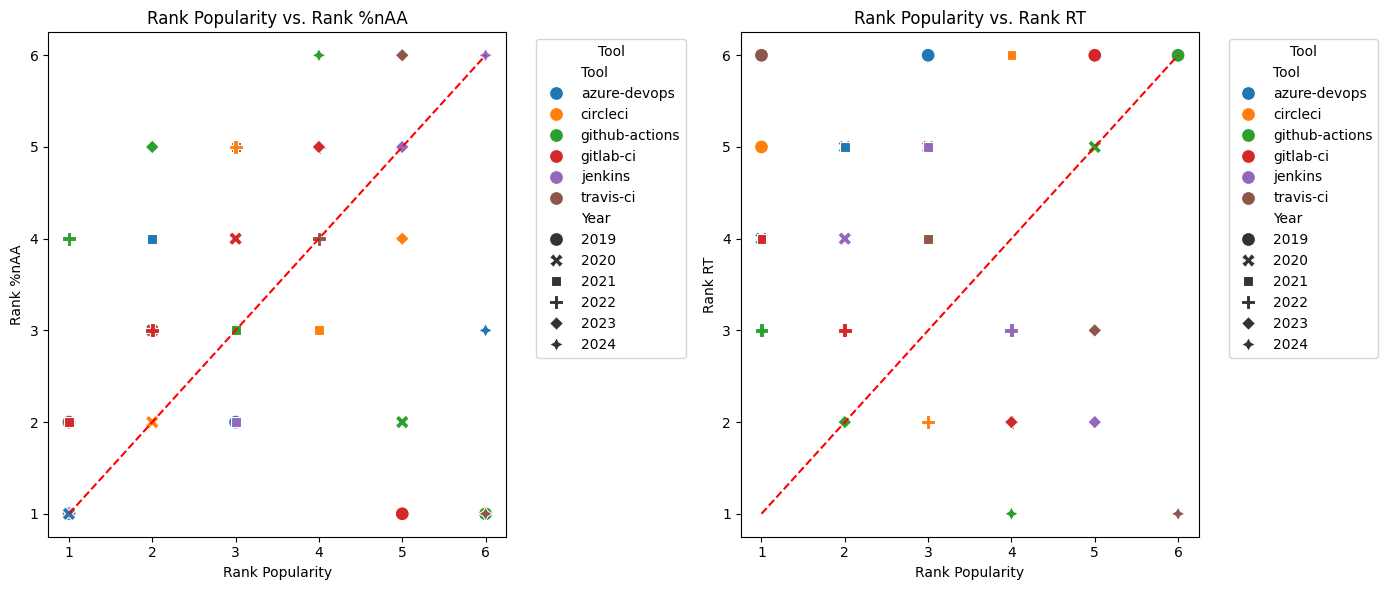

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' is the DataFrame with your rank data
# Rank Popularity vs. Rank %nAA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Rank (Popularity)', y='Rank (%nAA)', data=combined_df, hue='Tool', style='Year', s=100)
plt.title('Rank Popularity vs. Rank %nAA')
plt.xlabel('Rank Popularity')
plt.ylabel('Rank %nAA')
plt.plot([1, combined_df['Rank (Popularity)'].max()], [1, combined_df['Rank (Popularity)'].max()], 'r--')
plt.legend(title="Tool", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rank Popularity vs. Rank RT
plt.subplot(1, 2, 2)
sns.scatterplot(x='Rank (Popularity)', y='Rank (RT)', data=combined_df, hue='Tool', style='Year', s=100)
plt.title('Rank Popularity vs. Rank RT')
plt.xlabel('Rank Popularity')
plt.ylabel('Rank RT')
plt.plot([1, combined_df['Rank (Popularity)'].max()], [1, combined_df['Rank (Popularity)'].max()], 'r--')
plt.legend(title="Tool", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 6.- %nAA and RT vs Popularity

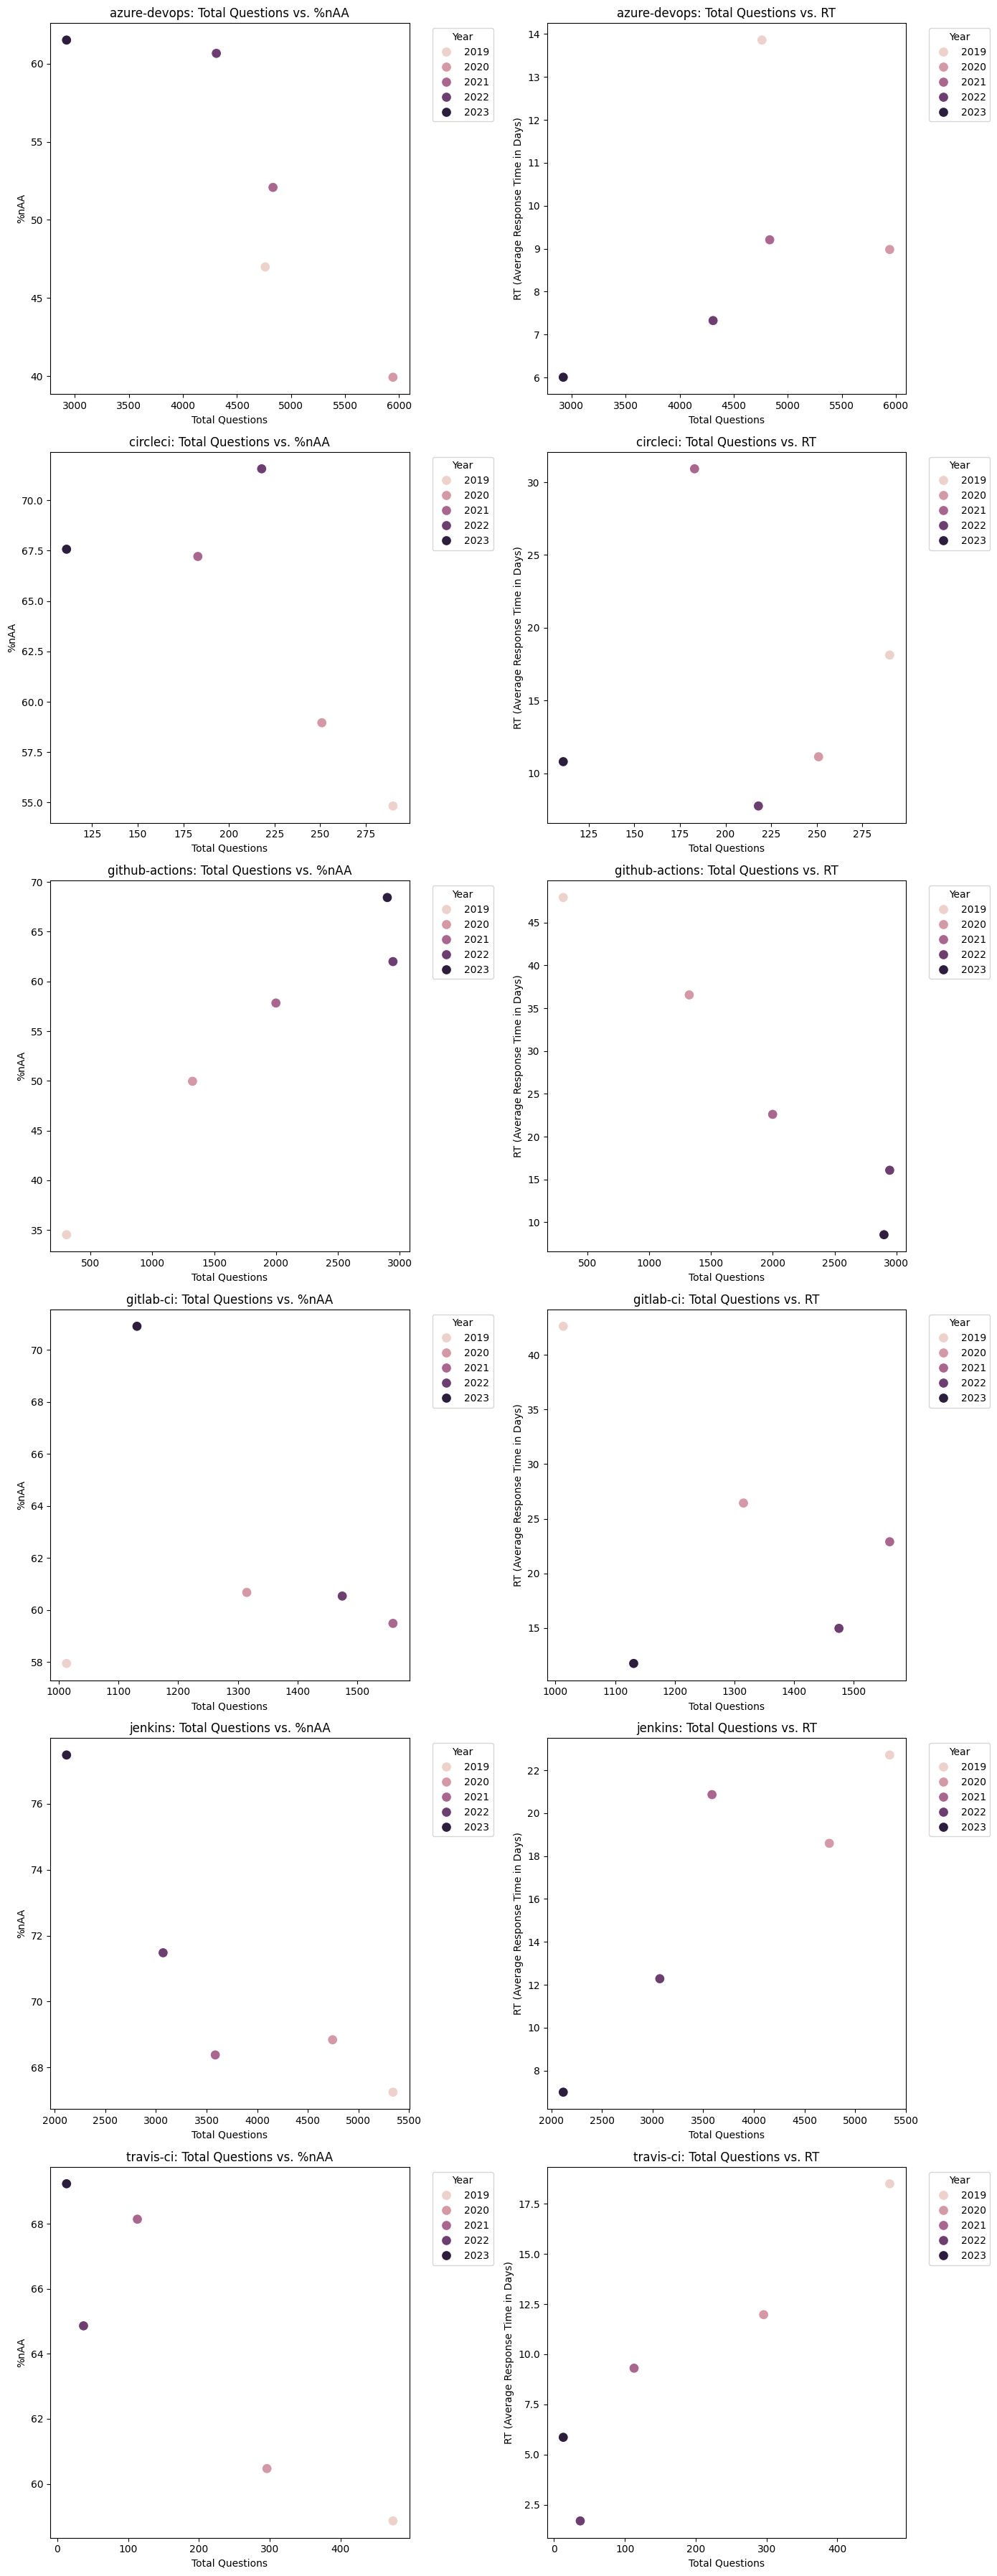

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


# Remove the year 2024
filtered_df = combined_df[combined_df['Year'] != 2024]

# List of unique tools in the DataFrame
tools = filtered_df['Tool'].unique()

# Set up the plotting environment
plt.figure(figsize=(14, len(tools) * 6))

for i, tool in enumerate(tools):
    tool_df = filtered_df[filtered_df['Tool'] == tool]
    
    # Plot Total Questions vs. %nAA
    plt.subplot(len(tools), 2, 2 * i + 1)
    sns.scatterplot(x='Total Questions', y='%nAA', data=tool_df, hue='Year', s=100)
    plt.title(f'{tool}: Total Questions vs. %nAA')
    plt.xlabel('Total Questions')
    plt.ylabel('%nAA')
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot Total Questions vs. RT
    plt.subplot(len(tools), 2, 2 * i + 2)
    sns.scatterplot(x='Total Questions', y='RT (Average Response Time in Days)', data=tool_df, hue='Year', s=100)
    plt.title(f'{tool}: Total Questions vs. RT')
    plt.xlabel('Total Questions')
    plt.ylabel('RT (Average Response Time in Days)')
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [29]:
# Remove the year 2024
filtered_df = combined_df[combined_df['Year'] != 2024]

# Initialize a dictionary to store the correlation results
correlation_results = {}

# Calculate the correlations for each tool
tools = filtered_df['Tool'].unique()

for tool in tools:
    tool_df = filtered_df[filtered_df['Tool'] == tool]
    
    # Calculate correlation between Total Questions and %nAA
    corr_nAA = tool_df['Total Questions'].corr(tool_df['%nAA'])
    
    # Calculate correlation between Total Questions and RT
    corr_RT = tool_df['Total Questions'].corr(tool_df['RT (Average Response Time in Days)'])
    
    # Store the results in the dictionary
    correlation_results[tool] = {
        'Correlation (Total Questions vs %nAA)': corr_nAA,
        'Correlation (Total Questions vs RT)': corr_RT
    }

# Convert the results to a DataFrame for easier viewing
correlation_df = pd.DataFrame(correlation_results).T
print(correlation_df)


                Correlation (Total Questions vs %nAA)  \
azure-devops                                -0.884598   
circleci                                    -0.701330   
github-actions                               0.971624   
gitlab-ci                                   -0.270068   
jenkins                                     -0.875577   
travis-ci                                   -0.897390   

                Correlation (Total Questions vs RT)  
azure-devops                               0.487261  
circleci                                   0.006772  
github-actions                            -0.977778  
gitlab-ci                                 -0.461482  
jenkins                                    0.880743  
travis-ci                                  0.941690  


## 7.- Using GitHub actions as Baseline

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out GitHub Actions as the baseline
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions'].set_index('Year')

# Initialize a list to store the results for all tools
relative_difficulty_list = []

# Loop through each tool and calculate the relative difficulty compared to GitHub Actions
for tool in tools:
    if tool != 'github-actions':
        tool_df = filtered_df[filtered_df['Tool'] == tool].set_index('Year')
        
        # Calculate the relative difference for %nAA and RT
        relative_nAA = tool_df['%nAA'] - gha_df['%nAA']
        relative_RT = tool_df['RT (Average Response Time in Days)'] - gha_df['RT (Average Response Time in Days)']
        
        # Combine the results into a DataFrame
        temp_df = pd.DataFrame({
            'Year': relative_nAA.index,
            'Tool': tool,
            'Relative %nAA': relative_nAA.values,
            'Relative RT': relative_RT.values
        })
        
        # Append the DataFrame to the list
        relative_difficulty_list.append(temp_df)

# Combine all results into a single DataFrame
relative_difficulty_df = pd.concat(relative_difficulty_list, ignore_index=True)

# Display the resulting DataFrame
print(relative_difficulty_df)


    Year          Tool  Relative %nAA  Relative RT
0   2019  azure-devops          12.46   -34.075618
1   2020  azure-devops         -10.03   -27.577897
2   2021  azure-devops          -5.75   -13.396802
3   2022  azure-devops          -1.34    -8.748641
4   2023  azure-devops          -6.93    -2.536007
5   2019      circleci          20.30   -29.814869
6   2020      circleci           9.00   -25.431455
7   2021      circleci           9.38     8.316783
8   2022      circleci           9.56    -8.329015
9   2023      circleci          -0.87     2.248982
10  2019     gitlab-ci          23.42    -5.313419
11  2020     gitlab-ci          10.72   -10.120368
12  2021     gitlab-ci           1.66     0.290943
13  2022     gitlab-ci          -1.46    -1.105480
14  2023     gitlab-ci           2.47     3.212878
15  2019       jenkins          32.72   -25.223498
16  2020       jenkins          18.88   -17.965571
17  2021       jenkins          10.55    -1.740363
18  2022       jenkins         

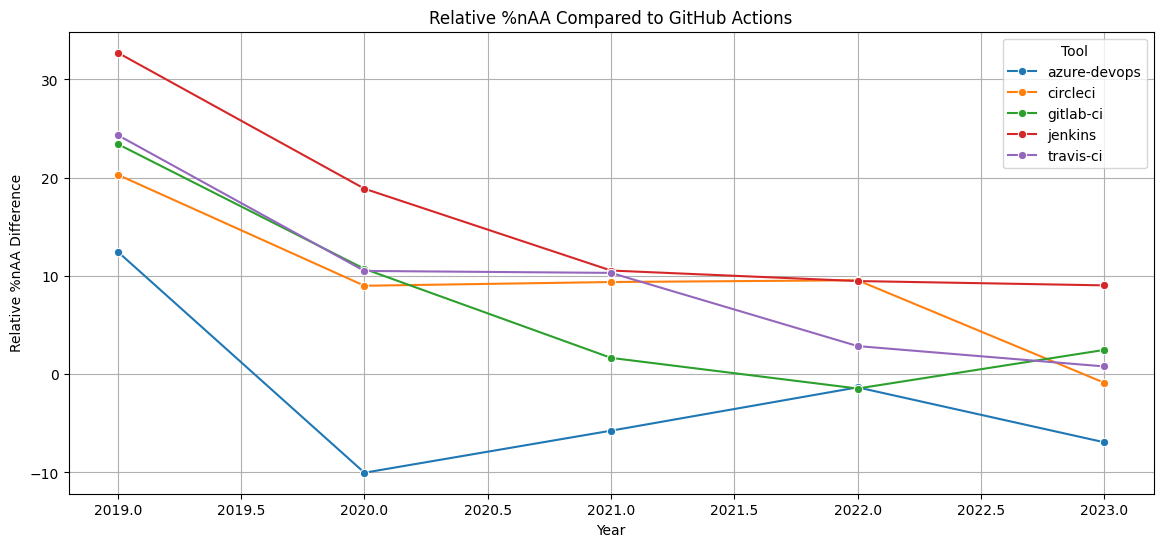

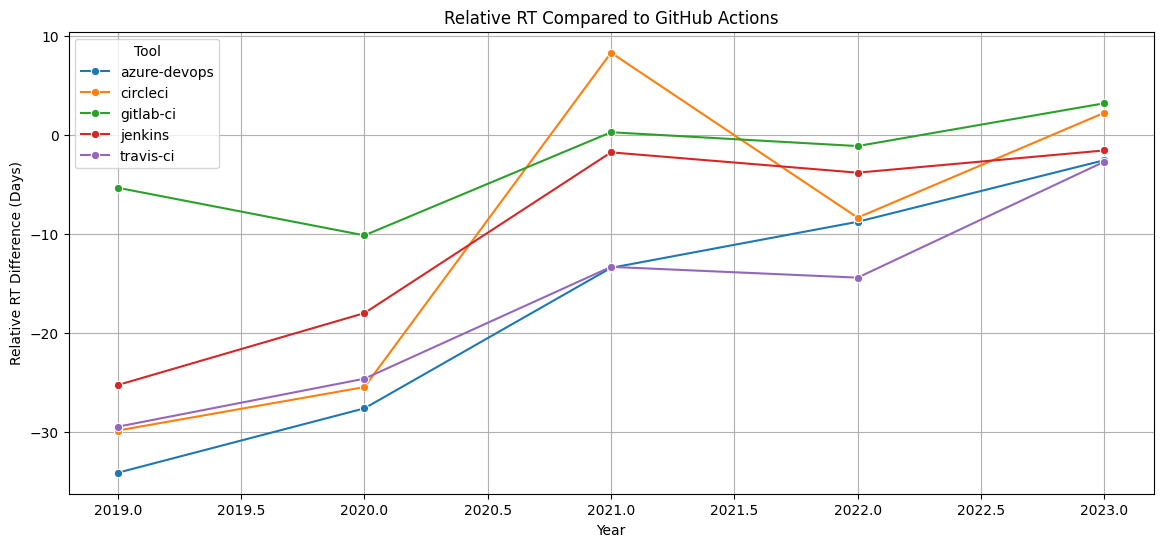

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the relative %nAA over time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Year', y='Relative %nAA', hue='Tool', data=relative_difficulty_df, marker='o')
plt.title('Relative %nAA Compared to GitHub Actions')
plt.xlabel('Year')
plt.ylabel('Relative %nAA Difference')
plt.legend(title='Tool')
plt.grid(True)
plt.show()

# Plotting the relative RT over time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Year', y='Relative RT', hue='Tool', data=relative_difficulty_df, marker='o')
plt.title('Relative RT Compared to GitHub Actions')
plt.xlabel('Year')
plt.ylabel('Relative RT Difference (Days)')
plt.legend(title='Tool')
plt.grid(True)
plt.show()


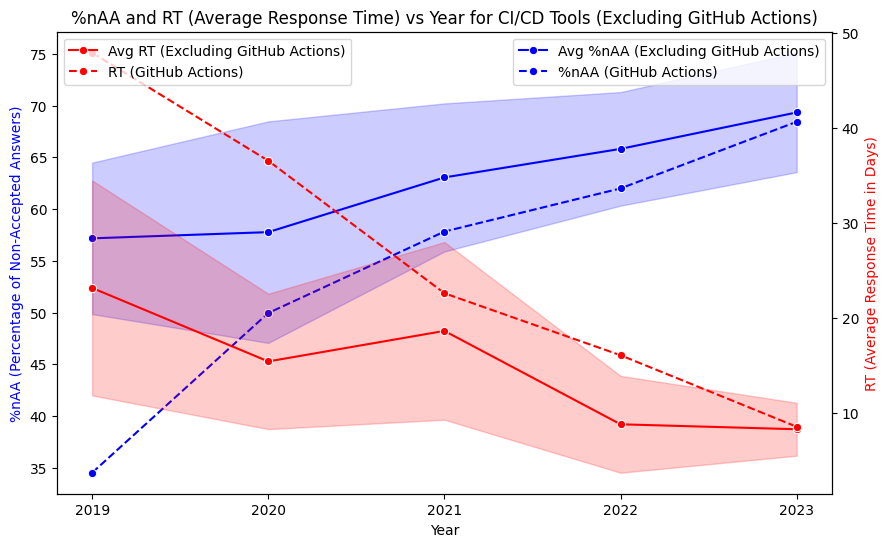

In [32]:
# Filter the data for GitHub Actions and other tools separately
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']
other_tools_df = filtered_df[filtered_df['Tool'] != 'github-actions']

# Calculate the average and standard deviation for %nAA and RT for all tools except GitHub Actions
avg_other_tools = other_tools_df.groupby('Year').agg({
    '%nAA': 'mean',
    'RT (Average Response Time in Days)': 'mean'
}).reset_index()

std_other_tools = other_tools_df.groupby('Year').agg({
    '%nAA': 'std',
    'RT (Average Response Time in Days)': 'std'
}).reset_index()

# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting %nAA vs Year for other tools (average) on the primary y-axis
sns.lineplot(x='Year', y='%nAA', data=avg_other_tools, marker='o', ax=ax1, label='Avg %nAA (Excluding GitHub Actions)', color='b')
sns.lineplot(x='Year', y='%nAA', data=gha_df, marker='o', ax=ax1, label='%nAA (GitHub Actions)', color='blue', linestyle='--')

# Adding shaded area for %nAA standard deviation
ax1.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['%nAA'] - std_other_tools['%nAA'], 
                 avg_other_tools['%nAA'] + std_other_tools['%nAA'], 
                 color='b', alpha=0.2)

# Creating a second y-axis for RT
ax2 = ax1.twinx()

# Plotting RT vs Year for other tools (average) on the second y-axis
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=avg_other_tools, marker='o', ax=ax2, label='Avg RT (Excluding GitHub Actions)', color='r')
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=gha_df, marker='o', ax=ax2, label='RT (GitHub Actions)', color='red', linestyle='--')

# Adding shaded area for RT standard deviation
ax2.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['RT (Average Response Time in Days)'] - std_other_tools['RT (Average Response Time in Days)'], 
                 avg_other_tools['RT (Average Response Time in Days)'] + std_other_tools['RT (Average Response Time in Days)'], 
                 color='r', alpha=0.2)

# Labels and title
plt.title('%nAA and RT (Average Response Time) vs Year for CI/CD Tools (Excluding GitHub Actions)')
ax1.set_xlabel('Year')
ax1.set_ylabel('%nAA (Percentage of Non-Accepted Answers)', color='b')
ax2.set_ylabel('RT (Average Response Time in Days)', color='r')

# Customizing the legends: Place the legends
ax1.legend(loc='upper right')  # %nAA legends
ax2.legend(loc='upper left')   # RT legends

# Set x-ticks to display only specific years
ax1.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file
plt.savefig('figs/nAA_RT_vs_time_excluding_gha.png')

# Show the plot
plt.show()



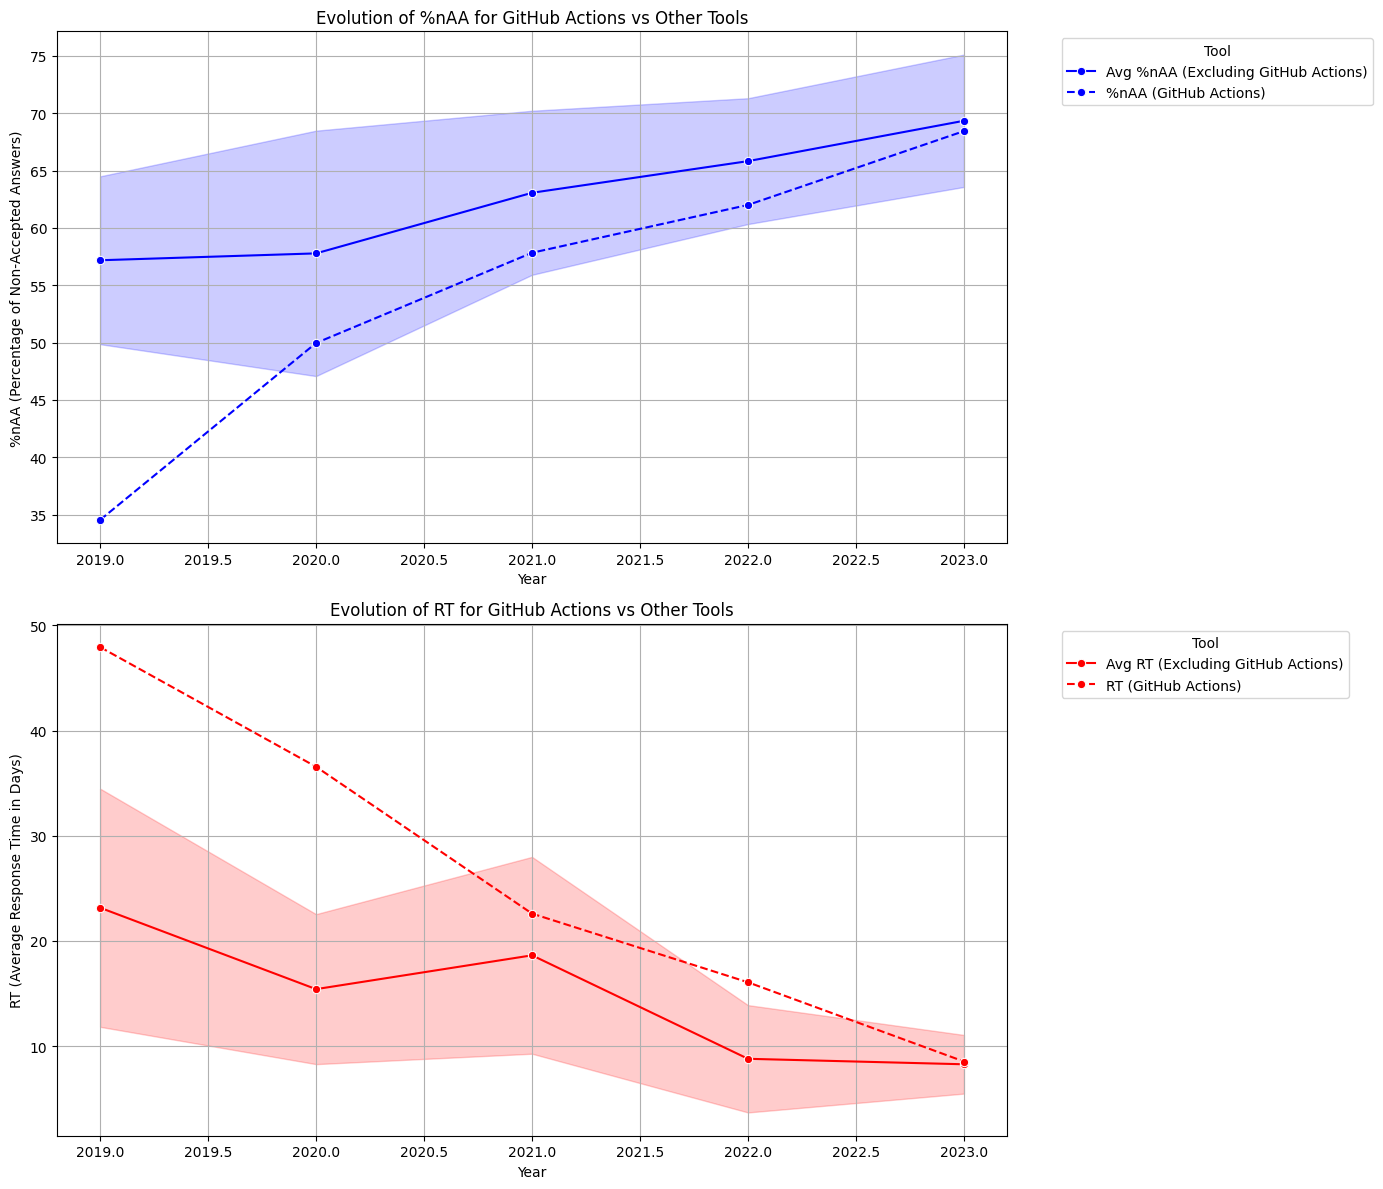

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate GitHub Actions and other tools
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']
other_tools_df = filtered_df[filtered_df['Tool'] != 'github-actions']

# Calculate the average and standard deviation for %nAA and RT for other tools
avg_other_tools = other_tools_df.groupby('Year').agg({
    '%nAA': 'mean',
    'RT (Average Response Time in Days)': 'mean'
}).reset_index()

std_other_tools = other_tools_df.groupby('Year').agg({
    '%nAA': 'std',
    'RT (Average Response Time in Days)': 'std'
}).reset_index()

# Set up the figure size
plt.figure(figsize=(14, 12))

# Plot 1: Evolution of %nAA for each tool over time
plt.subplot(2, 1, 1)

# Plotting the average %nAA for other tools with shaded area
sns.lineplot(x='Year', y='%nAA', data=avg_other_tools, marker='o', label='Avg %nAA (Excluding GitHub Actions)', color='b')
plt.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['%nAA'] - std_other_tools['%nAA'], 
                 avg_other_tools['%nAA'] + std_other_tools['%nAA'], 
                 color='b', alpha=0.2)

# Plotting GitHub Actions separately
sns.lineplot(x='Year', y='%nAA', data=gha_df, marker='o', label='%nAA (GitHub Actions)', color='blue', linestyle='--')

plt.title('Evolution of %nAA for GitHub Actions vs Other Tools')
plt.xlabel('Year')
plt.ylabel('%nAA (Percentage of Non-Accepted Answers)')
plt.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 2: Evolution of RT for each tool over time
plt.subplot(2, 1, 2)

# Plotting the average RT for other tools with shaded area
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=avg_other_tools, marker='o', label='Avg RT (Excluding GitHub Actions)', color='r')
plt.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['RT (Average Response Time in Days)'] - std_other_tools['RT (Average Response Time in Days)'], 
                 avg_other_tools['RT (Average Response Time in Days)'] + std_other_tools['RT (Average Response Time in Days)'], 
                 color='r', alpha=0.2)

# Plotting GitHub Actions separately
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=gha_df, marker='o', label='RT (GitHub Actions)', color='red', linestyle='--')

plt.title('Evolution of RT for GitHub Actions vs Other Tools')
plt.xlabel('Year')
plt.ylabel('RT (Average Response Time in Days)')
plt.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('figs/nAA_RT_vs_time_each_tool_vs_avg.png')

# Show the plots
plt.show()
